In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

from train.metrics_f1 import calc_f1_score

In [60]:
df_train_raw = pd.read_csv('train/data/train.csv')
df_test_raw = pd.read_csv('train/data/test.csv')

df_train_raw.sample(5)

,wagnum,month,target_month,target_day,5d_another_road_max,5d_naliv_mean,5d_ost_prob_min,60d_nasip_mean,30d_nasip_mean,5d_skoroport_mean,...,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,expected_srok_sl_y,expected_srok_sl_y_b,date_build_b
205250,1400,2023-02-01,1,1,1.0,0.0,14714.0,0.000000,0.000000,0.0,...,2,9,2,8,16.0,160000,0,30.460274,long,"(2007, 2017]"
17206,17207,2022-08-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,2,9,2,4,11.0,160000,0,33.021918,long,"(2007, 2017]"
22328,22329,2022-08-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,2,9,2,7,11.0,160000,0,22.126027,short,"(2007, 2017]"
145990,10087,2022-12-01,0,0,1.0,0.0,76423.0,0.766667,0.533333,0.0,...,22,2,3,7,11.0,160000,0,23.958904,short,"(2007, 2017]"
78579,10628,2022-10-01,1,1,1.0,0.0,1156.0,0.700000,0.700000,0.0,...,2,9,2,1,11.0,160000,0,21.336986,short,"(2000, 2007]"


In [61]:
df_train_raw.shape

(237561, 98)

In [62]:
df_train_raw.columns

Index(['wagnum', 'month', 'target_month', 'target_day', '5d_another_road_max',
       '5d_naliv_mean', '5d_ost_prob_min', '60d_nasip_mean', '30d_nasip_mean',
       '5d_skoroport_mean', '5d_soprovod_mean', '60d_naliv_mean',
       '30d_skoroport_mean', '5d_openvagons_mean', '5d_avg_distance_min',
       '10d_soprovod_mean', '30d_isload_mean', '10d_ost_prob_max',
       '30d_naval_mean', '5d_nasip_mean', '10d_nasip_mean', '60d_ost_prob_min',
       '5d_avg_distance_max', '30d_another_road_max', '30d_avg_distance_min',
       '60d_ost_prob_max', '60d_avg_distance_min', '5d_smerz_mean',
       '10d_naval_mean', '10d_prob_mean', '30d_smerz_mean',
       '60d_openvagons_mean', '5d_prob_mean', '5d_naval_mean',
       '60d_naval_mean', '30d_ost_prob_sum', '10d_openvagons_mean',
       '30d_ost_prob_max', '30d_avg_distance_max', '60d_another_road_max',
       '10d_skoroport_mean', '60d_avg_distance_max', '60d_ost_prob_sum',
       '5d_ost_prob_max', '5d_isload_mean', '30d_openvagons_mean',
   

In [66]:
import re

targets = ['target_month', 'target_day']
numerical = list(filter(lambda x: re.match(r'\d+[dm]_', x), df.columns))
categorical = ['kod_vrab', 'model',  'zavod_build', 'kuzov', 'telega', 'expected_srok_sl_y_b', 'date_build_b', 'manage_type', 'rod_id_x', 'reestr_state',
                'tormoz', 'tipvozd', 'tippogl', 'ownertype']
dates = ['month', 'date_kap', 'date_dep', 'date_pl_rem', 'last_rem_date', 'date_build', 'srok_sl']

numerical += [
    "days_to_pl_rem",
    "days_from_last_rem",
    "ost_prob",
    "gruz",
    "cnsi_gruz_capacity",
    "cnsi_volumek",
    "tara",
    "cnsi_probeg_dr",
    "cnsi_probeg_kr",
    "norma_km",
    "expected_srok_sl_y"
]

notna_features = ['date_kap', 'date_dep', 'date_iskl']
notna_features_res = [feature + '_notna' for feature in notna_features]
categorical += notna_features_res

print('Unused columns:')
for col in df_train_raw.columns:
    if col not in targets and col not in numerical and col not in categorical and col not in dates:
        print(col)

features = numerical + categorical + targets
train_features = numerical + categorical

medians = df_train_raw[numerical].median()

def preprcoess_df(df, test=False):
    for date in dates:
        df[date] = pd.to_datetime(df[date])
    df = df[df['month'] > '2022-08-01']

    for col in notna_features:
        df[col + '_notna'] = df[col].notna().astype(int)

    features = numerical + categorical + targets
    if test:
        features = train_features
    df = df[features]

    df[categorical] = df[categorical].astype('str')
    df[numerical] = df[numerical].fillna(medians)

    return df

df_train = preprcoess_df(df_train_raw)
df_test = preprcoess_df(df_test_raw, test=True)


df_train.shape, df_test.shape

Unused columns:
wagnum
ownership_type
rod_id_y
date_iskl


/tmp/ipykernel_12131/2226798027.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_notna'] = df[col].notna().astype(int)
/tmp/ipykernel_12131/2226798027.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_notna'] = df[col].notna().astype(int)
/tmp/ipykernel_12131/2226798027.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

((203586, 90), (33707, 88))

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def train(target):

    features = numerical + categorical + [target]
    data = df_train[features]
    month_to_predict = pd.to_datetime('2023-02-01')

    train_ind = df_train_raw['month'] < month_to_predict
    test_ind = df_train_raw['month'] == month_to_predict

    print(f"Train size {data[train_ind].shape}")
    print(f"Test size {data[test_ind].shape}")

    X_train = data[train_ind].drop(target, axis=1)
    y_train = data[train_ind][target]

    X_test = data[test_ind].drop(target, axis=1)
    y_test = data[test_ind][target]

    from catboost import CatBoostClassifier
    from catboost import Pool

    clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        random_seed=42,
        eval_metric='F1',
        cat_features=categorical,
        early_stopping_rounds=100,
    )

    clf.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=False,
        plot=True
    )

    y_pred = clf.predict(X_test)
    print(f"Score for {target}: {f1_score(y_test, y_pred)}")
    return clf


month_clf = train('target_month')
day_clf = train('target_day')


Train size (169878, 89)
Test size (33708, 89)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Score for target_month: 0.6247070639437563
Train size (169878, 89)
Test size (33708, 89)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Score for target_day: 0.4101326899879372


In [56]:
month_to_predict = pd.to_datetime('2023-02-01')

test_ind = df['month'] == month_to_predict
X_test = df_train.loc[test_ind, train_features]
y_month_test = df_train.loc[test_ind, 'target_month']
y_day_test = df_train.loc[test_ind, 'target_day']

moth_pred = month_clf.predict(X_test)
day_pred = day_clf.predict(X_test)

f1_month = f1_score(y_month_test, moth_pred)
f1_day = f1_score(y_day_test, day_pred)
print(f"Val f1 score is {(f1_day + f1_month) / 2}")

Train f1 score is 0.5174198769658468


In [76]:
len(sample), len(df_test)

(33707, 33707)

In [81]:
def predict(clf_day, clf_month, df):
    pred_day = clf_day.predict(df)
    pred_month = clf_month.predict(df)

    
    df_test_new = df_test_raw.copy()
    df_test_new['target_day'] = pred_day
    df_test_new['target_month'] = pred_month

    df_test_new = df_test_new[['wagnum', 'target_month', 'target_day']]
    sample = pd.read_csv('train/target/y_predict.csv')
    sample = sample.merge(df_test_new, on='wagnum', how='left')

    return sample

prediction = predict(day_clf, month_clf, df_test)
assert len(prediction) == len(df_test)

prediction.describe()

,wagnum,target_month,target_day
count,33707.000000,33707.000000,33707.000000
mean,17062.180437,0.068116,0.005963
std,9805.705493,0.251949,0.076992
min,0.000000,0.000000,0.000000
25%,8663.500000,0.000000,0.000000
50%,17115.000000,0.000000,0.000000
75%,25546.500000,0.000000,0.000000
max,33976.000000,1.000000,1.000000


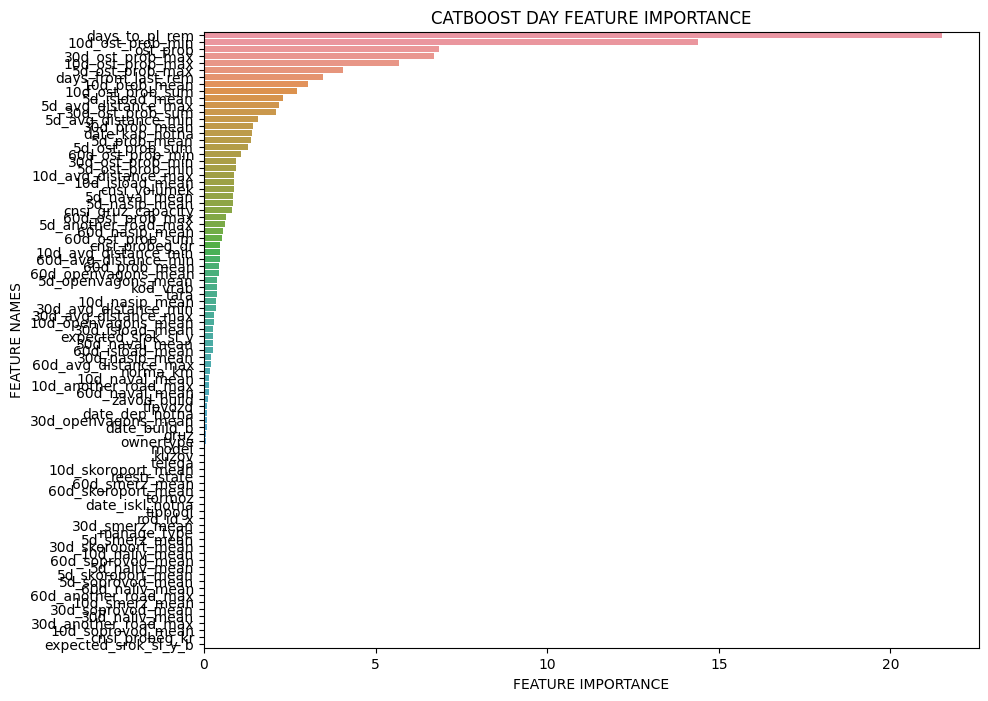

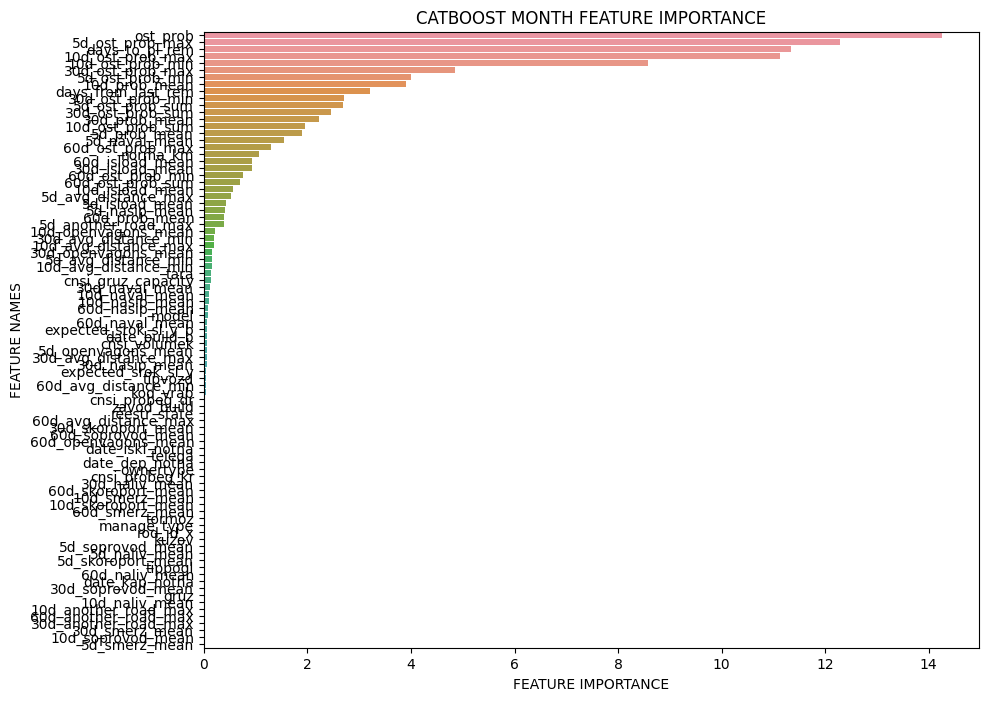

In [84]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})
    data.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=data['feature_importance'], y=data['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


plot_feature_importance(day_clf.get_feature_importance(), numerical + categorical, 'CATBOOST DAY ')
plot_feature_importance(month_clf.get_feature_importance(), numerical + categorical, 'CATBOOST MONTH ')

In [83]:
prediction.to_csv('predictions/first.csv', index=False)